
# DBTL Cycle with PyTorch MLP + GPyTorch GP + EI
# Comparing standard approach to latent representation w/ VAE

This notebook demonstrates a DBTL (Design-Build-Test-Learn) loop using:
- A deep neural network for predictive modeling (PyTorch)
- A Gaussian Process model for uncertainty estimation (GPyTorch)
- An Expected Improvement (EI) acquisition function


In [4]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch import nn
from scipy.stats import norm

torch.manual_seed(42)
np.random.seed(42)

def true_yield_function(X):
    return (np.sin(X[:, 0]) + 0.5 * X[:, 1] - 0.2 * X[:, 2] ** 2 + 
            np.random.normal(0, 0.1, size=X.shape[0]))

In [10]:
design_space_np = np.random.uniform(low=-3, high=3, size=(1000, 3))
design_space = torch.tensor(design_space_np, dtype=torch.float)

initial_indices = np.random.choice(len(design_space), size=10, replace=False)
X_train = torch.tensor(design_space_np[initial_indices], dtype=torch.float)
y_train = torch.tensor(true_yield_function(X_train.numpy()), dtype=torch.float)

In [11]:
class PredictiveMLP(nn.Module):
    def __init__(self, in_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

def train_predictive_model(model, X, y, epochs=100):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

mlp_model = PredictiveMLP()
train_predictive_model(mlp_model, X_train, y_train)
y_pred = mlp_model(design_space).detach()


In [13]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)
        )

    def forward(self, x):
        mean = self.mean_module(x)
        cov = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, cov)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
gp_model = GPRegressionModel(X_train, y_train, likelihood)

gp_model.train()
likelihood.train()
optimizer = torch.optim.Adam(gp_model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

for i in range(50):
    optimizer.zero_grad()
    output = gp_model(X_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()

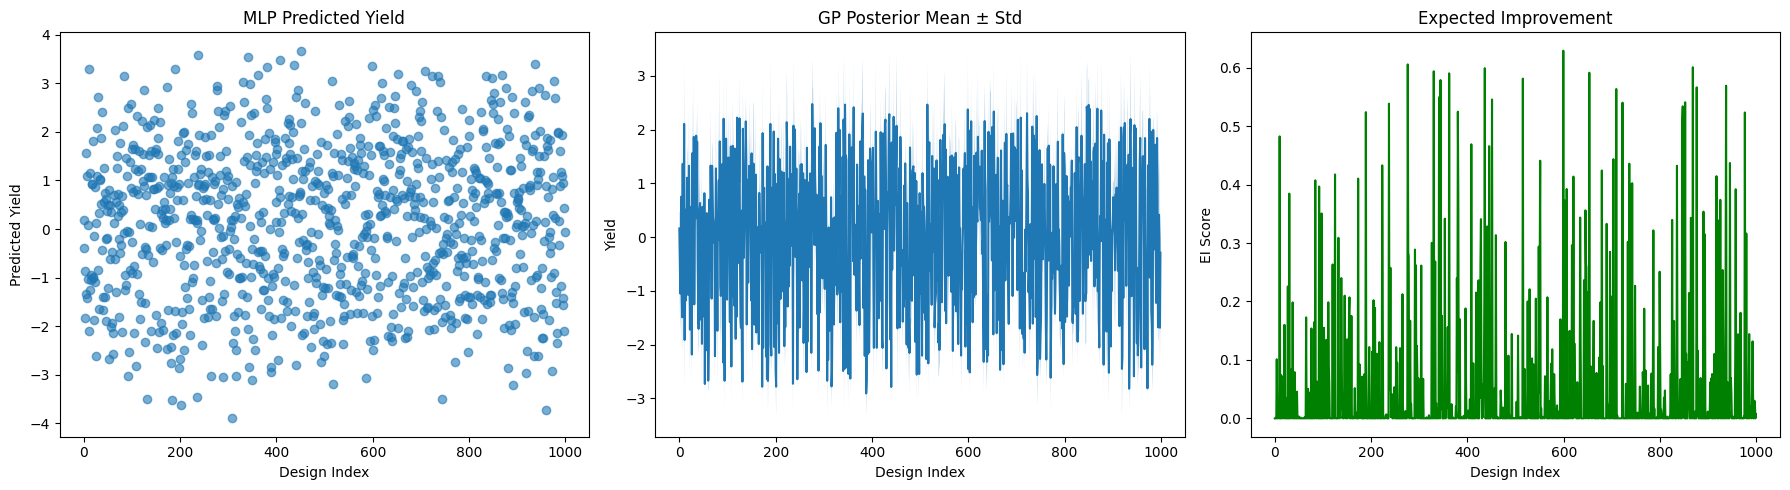

In [16]:
gp_model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = gp_model(design_space)
    mu = preds.mean
    sigma = preds.variance.sqrt()

y_best = y_train.max()
improvement = mu - y_best
Z = improvement / (sigma + 1e-8)
ei = improvement * torch.tensor(norm.cdf(Z)) + sigma * torch.tensor(norm.pdf(Z))

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(range(len(design_space)), y_pred.numpy(), alpha=0.6)
axs[0].set_title("MLP Predicted Yield")
axs[0].set_xlabel("Design Index")
axs[0].set_ylabel("Predicted Yield")

axs[1].plot(mu.numpy(), label='GP Mean')
axs[1].fill_between(range(len(sigma)), mu.numpy() - sigma.numpy(), mu.numpy() + sigma.numpy(), alpha=0.3)
axs[1].set_title("GP Posterior Mean ± Std")
axs[1].set_xlabel("Design Index")
axs[1].set_ylabel("Yield")

axs[2].plot(ei.numpy(), color='green')
axs[2].set_title("Expected Improvement")
axs[2].set_xlabel("Design Index")
axs[2].set_ylabel("EI Score")

plt.tight_layout()
plt.show()


Training VAE on design space...
Epoch 0, Loss: 8736.8184
Epoch 50, Loss: 3418.6445
Epoch 100, Loss: 2970.7114
Epoch 150, Loss: 2462.8523


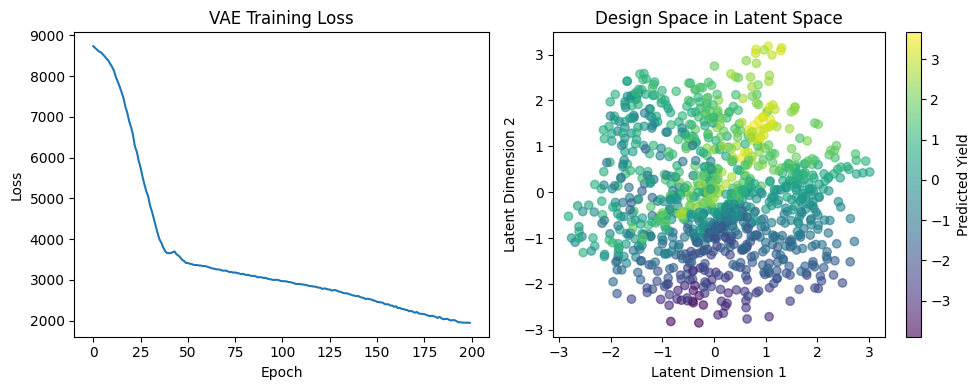

In [17]:
import torch.nn.functional as F
from torch.distributions import Normal

class VAE(nn.Module):
    def __init__(self, input_dim=3, latent_dim=2, hidden_dim=64):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Latent space parameters
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    """VAE loss with KL divergence and reconstruction loss"""
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kl_loss

def train_vae(vae, data, epochs=200, lr=1e-3, beta=1.0):
    """Train the VAE on the design space data"""
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
    vae.train()
    
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        x_recon, mu, logvar, z = vae(data)
        loss = vae_loss(x_recon, data, mu, logvar, beta)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    
    return losses

# Train the VAE on the design space
print("Training VAE on design space...")
vae = VAE(input_dim=3, latent_dim=2, hidden_dim=64)
vae_losses = train_vae(vae, design_space, epochs=200, beta=0.1)

# Visualize VAE training
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(vae_losses)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Encode the design space to latent space
vae.eval()
with torch.no_grad():
    _, mu_latent, _, z_latent = vae(design_space)
    
# Visualize the latent space
plt.subplot(1, 2, 2)
plt.scatter(z_latent[:, 0].numpy(), z_latent[:, 1].numpy(), alpha=0.6, c=y_pred.numpy(), cmap='viridis')
plt.colorbar(label='Predicted Yield')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Design Space in Latent Space')
plt.tight_layout()
plt.show()

In [18]:
class LatentSpaceGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # Note: train_x is now in latent space (2D instead of 3D)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)
        )

    def forward(self, x):
        mean = self.mean_module(x)
        cov = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, cov)

def train_latent_gp(vae, X_train, y_train, epochs=50):
    """Train GP in latent space"""
    vae.eval()
    
    # Encode training data to latent space
    with torch.no_grad():
        _, mu_train, _, z_train = vae(X_train)
    
    # Create and train GP in latent space
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    latent_gp = LatentSpaceGP(z_train, y_train, likelihood)
    
    latent_gp.train()
    likelihood.train()
    optimizer = torch.optim.Adam(latent_gp.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, latent_gp)
    
    for i in range(epochs):
        optimizer.zero_grad()
        output = latent_gp(z_train)
        loss = -mll(output, y_train)
        loss.backward()
        optimizer.step()
    
    return latent_gp, likelihood, z_train

# Train GP in latent space
print("Training GP in latent space...")
latent_gp, latent_likelihood, z_train_latent = train_latent_gp(vae, X_train, y_train)

# Make predictions in latent space
latent_gp.eval()
latent_likelihood.eval()

with torch.no_grad():
    latent_preds = latent_gp(z_latent)
    latent_mu = latent_preds.mean
    latent_sigma = latent_preds.variance.sqrt()

# Compute EI in latent space
y_best = y_train.max()
latent_improvement = latent_mu - y_best
latent_Z = latent_improvement / (latent_sigma + 1e-8)
latent_ei = latent_improvement * torch.tensor(norm.cdf(latent_Z)) + latent_sigma * torch.tensor(norm.pdf(latent_Z))

print(f"Latent GP completed. Max EI: {latent_ei.max().item():.4f}")

Training GP in latent space...
Latent GP completed. Max EI: 0.0943


In [24]:
def generate_latent_candidates(vae, latent_gp, latent_likelihood, n_candidates=100, n_optimization_steps=50):
    """Generate new candidate points by optimizing in latent space"""
    vae.eval()
    latent_gp.eval()
    latent_likelihood.eval()
    
    # Start with random points in latent space
    z_candidates = torch.randn(n_candidates, vae.latent_dim, requires_grad=True)
    optimizer = torch.optim.Adam([z_candidates], lr=0.1)
    
    for _ in range(n_optimization_steps):
        optimizer.zero_grad()
        
        # Compute EI for current candidates
        preds = latent_gp(z_candidates)
        mu = preds.mean
        sigma = preds.variance.sqrt()
        
        y_best = y_train.max()
        improvement = mu - y_best
        Z = improvement / (sigma + 1e-8)
        ei = improvement * torch.from_numpy(norm.cdf(Z.detach().cpu().numpy())).to(Z.device) \
             + sigma * torch.from_numpy(norm.pdf(Z.detach().cpu().numpy())).to(Z.device)
        
        # Optimize for maximum EI (minimize negative EI)
        loss = -ei.mean()
        loss.backward()
        optimizer.step()
    
    # Decode back to original space
    with torch.no_grad():
        x_candidates = vae.decode(z_candidates.detach())
    
    return x_candidates, z_candidates.detach()

# Generate new candidates
print("Generating new candidates in latent space...")
x_new_candidates, z_new_candidates = generate_latent_candidates(vae, latent_gp, latent_likelihood)

# Evaluate candidates with true function
with torch.no_grad():
    candidate_yields = torch.tensor(true_yield_function(x_new_candidates.detach().numpy()))

# Find best candidate
best_idx = candidate_yields.argmax()
best_candidate = x_new_candidates[best_idx].detach()
best_yield = candidate_yields[best_idx].detach()

print(f"Best candidate: {best_candidate.numpy()}")
print(f"Best yield: {best_yield.item():.4f}")
print(f"Current best yield: {y_train.max().item():.4f}")

Generating new candidates in latent space...
Best candidate: [2.1580544 3.1999817 1.2086614]
Best yield: 2.3709
Current best yield: 2.0305


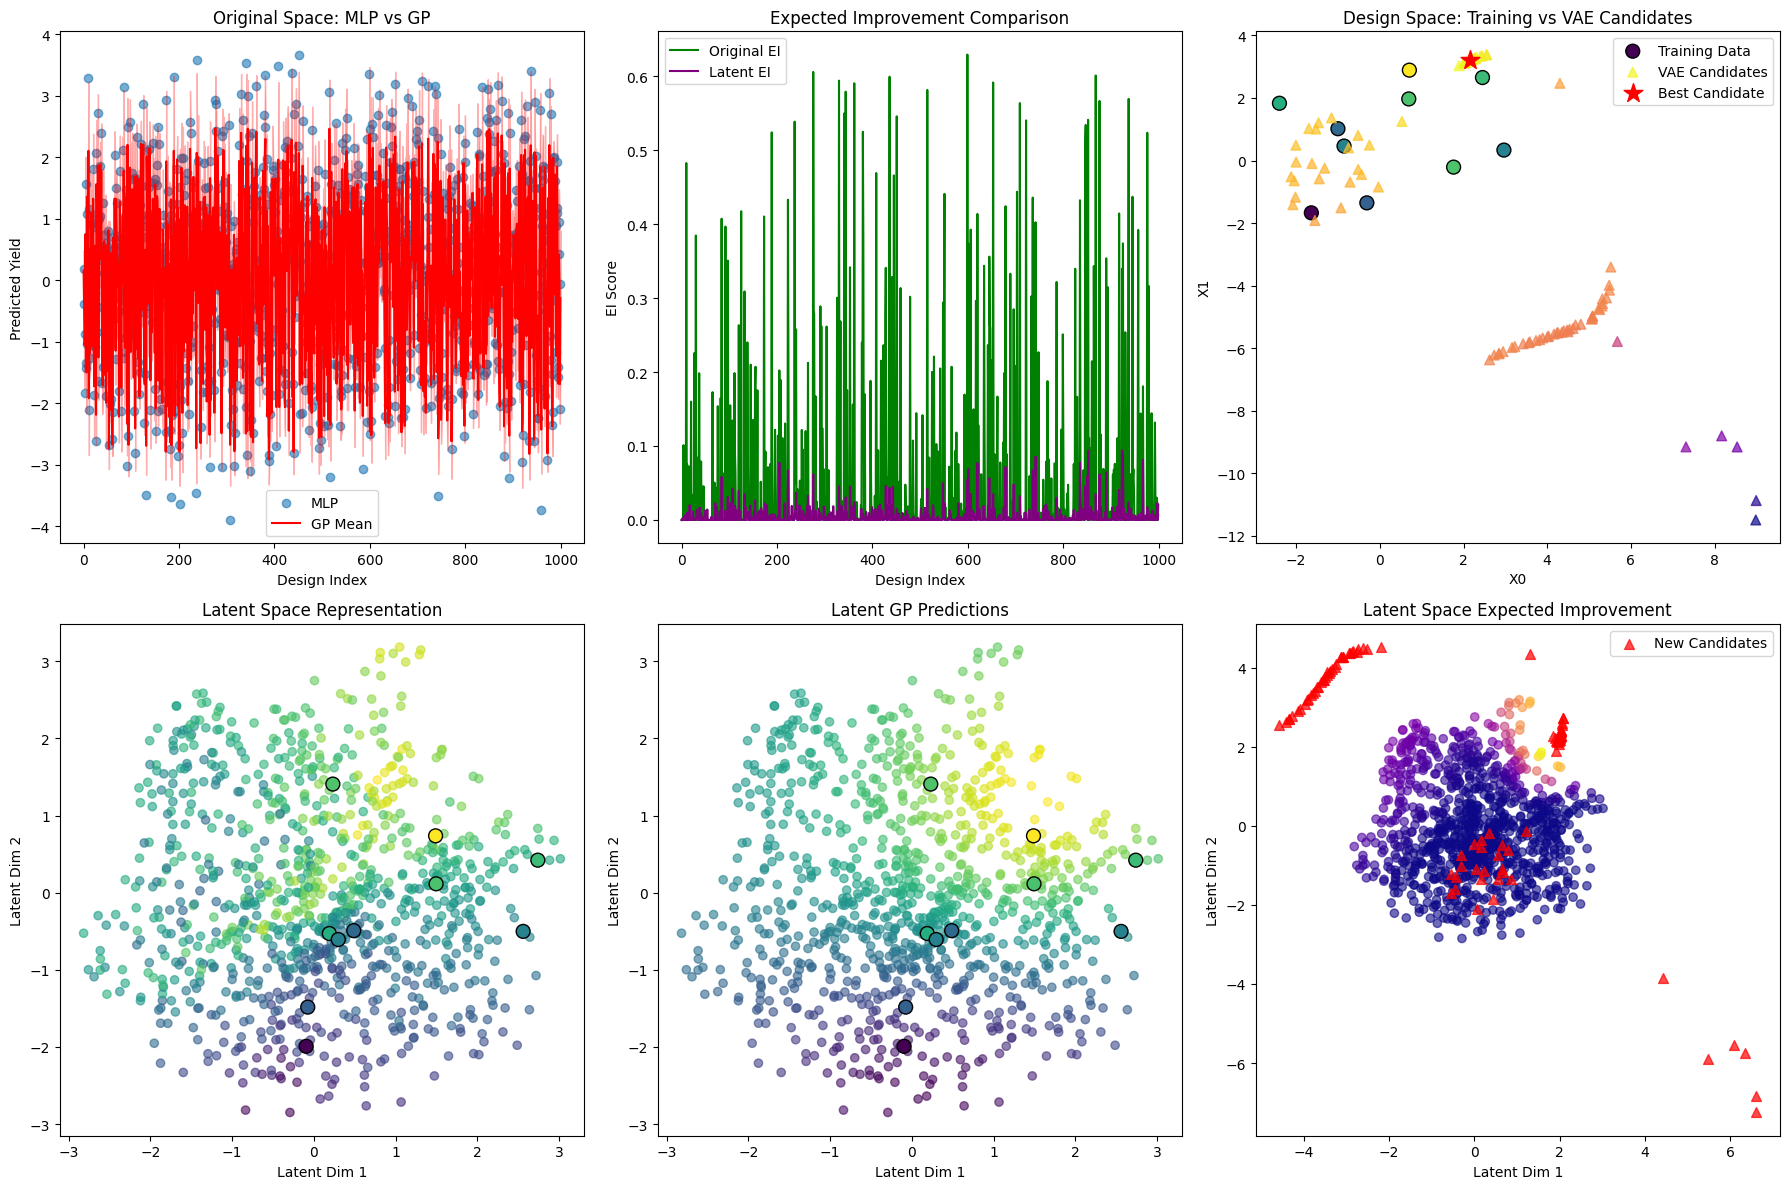


DBTL PIPELINE PERFORMANCE COMPARISON
Original GP - Max EI: 0.6291
Latent GP - Max EI: 0.0943
Current best yield: 2.0305
VAE best candidate yield: 2.3709
Improvement: 0.3404


In [25]:
# Comprehensive visualization comparing different approaches
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Original space comparisons
axes[0, 0].scatter(range(len(design_space)), y_pred.numpy(), alpha=0.6, label='MLP')
axes[0, 0].plot(mu.numpy(), label='GP Mean', color='red')
axes[0, 0].fill_between(range(len(sigma)), mu.numpy() - sigma.numpy(), 
                       mu.numpy() + sigma.numpy(), alpha=0.3, color='red')
axes[0, 0].set_title("Original Space: MLP vs GP")
axes[0, 0].set_xlabel("Design Index")
axes[0, 0].set_ylabel("Predicted Yield")
axes[0, 0].legend()

axes[0, 1].plot(ei.numpy(), color='green', label='Original EI')
axes[0, 1].plot(latent_ei.numpy(), color='purple', label='Latent EI')
axes[0, 1].set_title("Expected Improvement Comparison")
axes[0, 1].set_xlabel("Design Index")
axes[0, 1].set_ylabel("EI Score")
axes[0, 1].legend()

# Training data and new candidates in original space
axes[0, 2].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, marker='o', 
                  cmap='viridis', label='Training Data', edgecolors='black')
axes[0, 2].scatter(x_new_candidates[:, 0], x_new_candidates[:, 1], 
                  c=candidate_yields, s=50, marker='^', cmap='plasma', 
                  label='VAE Candidates', alpha=0.7)
axes[0, 2].scatter(best_candidate[0], best_candidate[1], c='red', s=200, 
                  marker='*', label='Best Candidate')
axes[0, 2].set_xlabel('X0')
axes[0, 2].set_ylabel('X1')
axes[0, 2].set_title('Design Space: Training vs VAE Candidates')
axes[0, 2].legend()

# Row 2: Latent space analysis
axes[1, 0].scatter(z_latent[:, 0].numpy(), z_latent[:, 1].numpy(), 
                  c=y_pred.numpy(), alpha=0.6, cmap='viridis')
axes[1, 0].scatter(z_train_latent[:, 0].numpy(), z_train_latent[:, 1].numpy(), 
                  c=y_train.numpy(), s=100, marker='o', edgecolors='black')
axes[1, 0].set_xlabel('Latent Dim 1')
axes[1, 0].set_ylabel('Latent Dim 2')
axes[1, 0].set_title('Latent Space Representation')

# Latent space GP predictions
axes[1, 1].scatter(z_latent[:, 0].numpy(), z_latent[:, 1].numpy(), 
                  c=latent_mu.numpy(), alpha=0.6, cmap='viridis')
axes[1, 1].scatter(z_train_latent[:, 0].numpy(), z_train_latent[:, 1].numpy(), 
                  c=y_train.numpy(), s=100, marker='o', edgecolors='black')
axes[1, 1].set_xlabel('Latent Dim 1')
axes[1, 1].set_ylabel('Latent Dim 2')
axes[1, 1].set_title('Latent GP Predictions')

# Latent space EI
axes[1, 2].scatter(z_latent[:, 0].numpy(), z_latent[:, 1].numpy(), 
                  c=latent_ei.numpy(), alpha=0.6, cmap='plasma')
axes[1, 2].scatter(z_new_candidates[:, 0].numpy(), z_new_candidates[:, 1].numpy(), 
                  c='red', s=50, marker='^', alpha=0.7, label='New Candidates')
axes[1, 2].set_xlabel('Latent Dim 1')
axes[1, 2].set_ylabel('Latent Dim 2')
axes[1, 2].set_title('Latent Space Expected Improvement')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Performance comparison
print("\n" + "="*60)
print("DBTL PIPELINE PERFORMANCE COMPARISON")
print("="*60)
print(f"Original GP - Max EI: {ei.max().item():.4f}")
print(f"Latent GP - Max EI: {latent_ei.max().item():.4f}")
print(f"Current best yield: {y_train.max().item():.4f}")
print(f"VAE best candidate yield: {best_yield.item():.4f}")
print(f"Improvement: {(best_yield.item() - y_train.max().item()):.4f}")
print("="*60)

Running complete DBTL loop with VAE...

--- DBTL Iteration 1 ---
Best candidate: [2.053903  3.1239243 0.8177816]
New yield: 2.4021
Current best: 2.4021

--- DBTL Iteration 2 ---
Best candidate: [1.7777262 2.9680936 0.7991352]
New yield: 2.4622
Current best: 2.4622

--- DBTL Iteration 3 ---
Best candidate: [2.097747  3.1681423 1.5078566]
New yield: 2.1983
Current best: 2.4622

--- DBTL Iteration 4 ---
Best candidate: [1.5240974 2.776302  0.3589604]
New yield: 2.5106
Current best: 2.5106

--- DBTL Iteration 5 ---
Best candidate: [1.698067   2.9043355  0.59090966]
New yield: 2.5351
Current best: 2.5351
Best candidate: [2.097747  3.1681423 1.5078566]
New yield: 2.1983
Current best: 2.4622

--- DBTL Iteration 4 ---
Best candidate: [1.5240974 2.776302  0.3589604]
New yield: 2.5106
Current best: 2.5106

--- DBTL Iteration 5 ---
Best candidate: [1.698067   2.9043355  0.59090966]
New yield: 2.5351
Current best: 2.5351


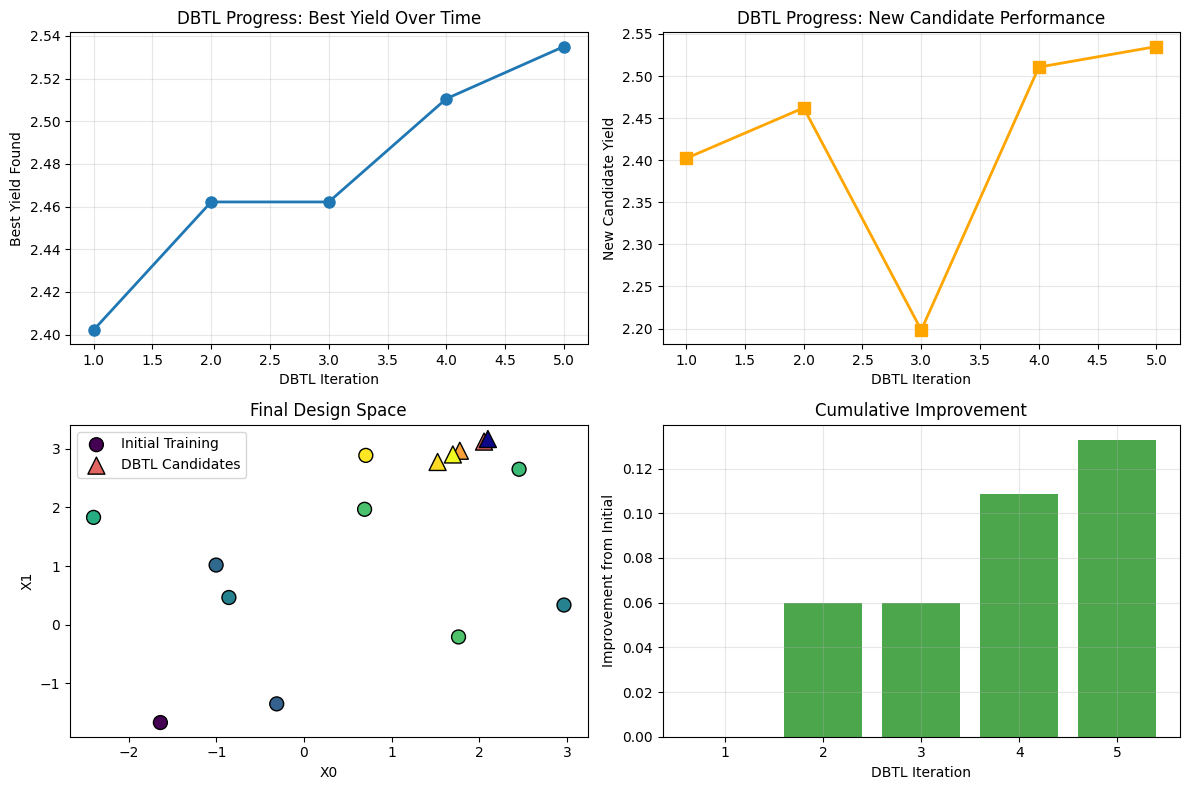


Final Results:
Initial best yield: 2.0305
Final best yield: 2.5351
Total improvement: 0.5046


In [27]:
def complete_dbtl_loop_with_vae(vae, initial_X, initial_y, n_iterations=5):
    """Complete DBTL loop using VAE-enhanced optimization"""
    
    X_current = initial_X.clone()
    y_current = initial_y.clone()
    
    results = {
        'iteration': [],
        'best_yield': [],
        'new_candidate': [],
        'new_yield': []
    }
    
    for iteration in range(n_iterations):
        print(f"\n--- DBTL Iteration {iteration + 1} ---")
        
        # DESIGN: Train GP in latent space
        latent_gp, latent_likelihood, z_train = train_latent_gp(vae, X_current, y_current, epochs=30)
        
        # BUILD: Generate new candidates
        x_candidates, z_candidates = generate_latent_candidates(
            vae, latent_gp, latent_likelihood, n_candidates=50, n_optimization_steps=30
        )
        
        # TEST: Evaluate candidates
        with torch.no_grad():
            candidate_yields = torch.tensor(true_yield_function(x_candidates.numpy()), dtype=torch.float32)
        
        # Select best candidate
        best_idx = candidate_yields.argmax()
        best_candidate = x_candidates[best_idx]
        best_candidate_yield = candidate_yields[best_idx]
        
        # LEARN: Update dataset
        X_current = torch.cat([X_current, best_candidate.unsqueeze(0)])
        y_current = torch.cat([y_current, best_candidate_yield.unsqueeze(0)])
        
        # Record results
        results['iteration'].append(iteration + 1)
        results['best_yield'].append(y_current.max().item())
        results['new_candidate'].append(best_candidate.numpy())
        results['new_yield'].append(best_candidate_yield.item())
        
        print(f"Best candidate: {best_candidate.numpy()}")
        print(f"New yield: {best_candidate_yield.item():.4f}")
        print(f"Current best: {y_current.max().item():.4f}")
    
    return results, X_current, y_current

# Run the complete DBTL loop
print("Running complete DBTL loop with VAE...")
dbtl_results, final_X, final_y = complete_dbtl_loop_with_vae(vae, X_train, y_train)

# Visualize DBTL progress
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(dbtl_results['iteration'], dbtl_results['best_yield'], 'o-', linewidth=2, markersize=8)
plt.xlabel('DBTL Iteration')
plt.ylabel('Best Yield Found')
plt.title('DBTL Progress: Best Yield Over Time')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(dbtl_results['iteration'], dbtl_results['new_yield'], 's-', color='orange', linewidth=2, markersize=8)
plt.xlabel('DBTL Iteration')
plt.ylabel('New Candidate Yield')
plt.title('DBTL Progress: New Candidate Performance')
plt.grid(True, alpha=0.3)

# Show final design space with all evaluated points
plt.subplot(2, 2, 3)
plt.scatter(final_X[:len(X_train), 0], final_X[:len(X_train), 1], 
           c=final_y[:len(X_train)], s=100, marker='o', cmap='viridis', 
           label='Initial Training', edgecolors='black')
plt.scatter(final_X[len(X_train):, 0], final_X[len(X_train):, 1], 
           c=final_y[len(X_train):], s=150, marker='^', cmap='plasma', 
           label='DBTL Candidates', edgecolors='black')
plt.xlabel('X0')
plt.ylabel('X1')
plt.title('Final Design Space')
plt.legend()

# Show improvement over iterations
plt.subplot(2, 2, 4)
improvements = [dbtl_results['best_yield'][i] - dbtl_results['best_yield'][0] 
               for i in range(len(dbtl_results['best_yield']))]
plt.bar(dbtl_results['iteration'], improvements, alpha=0.7, color='green')
plt.xlabel('DBTL Iteration')
plt.ylabel('Improvement from Initial')
plt.title('Cumulative Improvement')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"Initial best yield: {y_train.max().item():.4f}")
print(f"Final best yield: {final_y.max().item():.4f}")
print(f"Total improvement: {(final_y.max().item() - y_train.max().item()):.4f}")